# Sledování výšky objektu

V této úloze se budeme věnovat sledování výšky zrychleně stoupajícího objektu. Tato úloha byla teoreticky probrána na přednášce. Připomeňme, že pro pohyb s konstantním zrychlením $a$, počáteční rychlostí $v_0$ a výškou záchytu označenou jako počátek ($y_0 = 0$) platí

$$
    y_t = v_0 t + \frac{1}{2} a t^2 + \varepsilon_t, \qquad \text{iid}\quad \varepsilon_t \sim \mathcal{N}(0, \sigma^2).
$$

Modelovat budeme sekvenčně, tj. půjdeme postupně po časových okamžicích $t=1, t=2, \ldots$ a pokaždé provedeme bayesovský update apriorní distribuce aktuálním měřením výšky $y_t$ a aktuálním regresorem $x_t$. Odhadovat budeme tyto parametry:
- $\beta = [\beta_1, \beta_2]^\intercal = [v_0, a]$ - regresní koeficienty,
- $\sigma^2$ - variance šumu měření.

Jelikož uvažujeme šum normální, potom model je normální,

$$
y_t \sim \mathcal{N}(\beta^\intercal x_t, \sigma^2).
$$

Použijeme konjugované *normální inverzní-gama* apriorní rozdělení, neboť aposteriorní distribuce bude analyticky dostupná.

In [1]:
import sys
sys.path.insert(0, '../zdrojaky')

import numpy as np
import matplotlib.pylab as plt
from nig import NiG                        # třída s NiG apriornem
np.set_printoptions(precision=2)

Natáhneme data a **zjistíme jejich délku**.

In [2]:
y = np.load('c1-tracking.npz')['y']

#---------------------------------------------
# Vložte do proměnné ndat délku y 
# bude označovat počet měření.
ndat = y.shape[0]
#---------------------------------------------
print('Máme {0} měření'.format(ndat))

Máme 80 měření


Vykreslíme jak data vypadají - pro jednoduchost bez popisků.

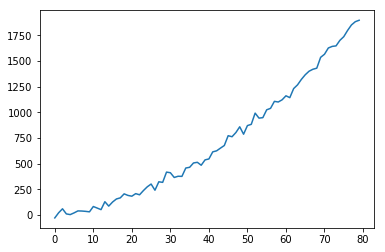

In [3]:
plt.plot(y)
plt.show()

Pustíme se do sekvenčního odhadu. Připomeňme znovu model, budeme jej potřebovat:

$$
y_t = v_0 t + \frac{1}{2} a t^2 + \varepsilon_t =
\underbrace{
\begin{bmatrix}
v_0 \\
a
\end{bmatrix}^\intercal
}_{\beta^\intercal}
\underbrace{
\begin{bmatrix}
t \\
t^2
\end{bmatrix}
}_{x_t}
+ \varepsilon_t.
$$

In [7]:
xi0 = np.diag([10000, .1, .1])   # Apriorní xí_0
nu0 = 5.                         # Apriorní ní_0
regmodel = NiG(xi0, nu0)         # instance normální inv. gamma apriorní distribuce

for t in range(ndat):
    yt = y[t]
    ##############################################
    # Do xt vložte místo *** správnou podobu regresoru x_t
    # (nezapomeňte že v pythonu jde t od nuly
    # ve fyzice t=1,2,...
    xt = np.array([t+1, 0.5*(t+1)**2])
    ##############################################
    
    regmodel.update(yt, xt)      # update apriorna novými měřeními
    regmodel.log()               # logování hyperparametrů a odhadů

Podíváme se na poslední aposteriorní odhady:

In [8]:
print('Finální odhad beta: ', regmodel.Ebeta)
print('Finální odhad sigma2: ', regmodel.Esigma2)
print('Var(beta): ', regmodel.var_beta)
print('Var(sigma2): ', regmodel.var_sigma2)

Finální odhad beta:  [ 3.95  0.5 ]
Finální odhad sigma2:  889.694731304
Var(beta):  [  8.19e-02   8.42e-05]
Var(sigma2):  19544.6102447


Vykreslíme grafy odhadů. **Zkuste upravit kód tak, aby byl vidět průběh odhadů v "ustáleném* stavu.**

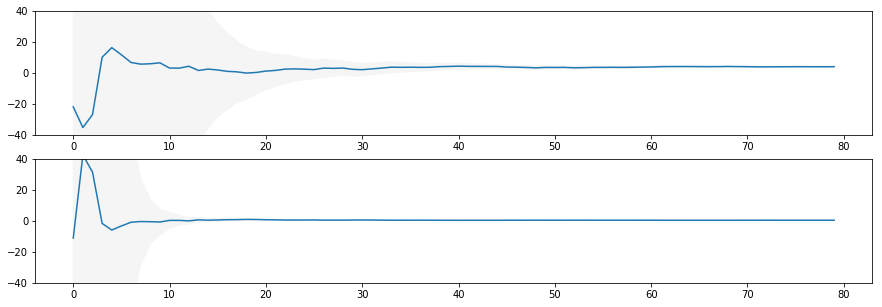

In [9]:
Ebeta_log = np.array(regmodel.Ebeta_log)
std_beta_log = np.array(regmodel.var_beta_log)

plt.figure(figsize=(15,5))
plt.subplot(211)
plt.plot(Ebeta_log[:, 0])
plt.fill_between(np.arange(ndat),
                 Ebeta_log[:, 0] + 3 * std_beta_log[:, 0],
                 Ebeta_log[:, 0] - 3 * std_beta_log[:, 0],
                 color='whitesmoke'
                 )
plt.ylim(-40, 40)

plt.subplot(212)
plt.plot(Ebeta_log[:, 1])
plt.fill_between(np.arange(ndat),
                 Ebeta_log[:, 1] + 3 * std_beta_log[:, 1],
                 Ebeta_log[:, 1] - 3 * std_beta_log[:, 1],
                 color='whitesmoke'
                 )
plt.ylim(-40, 40)
plt.show()

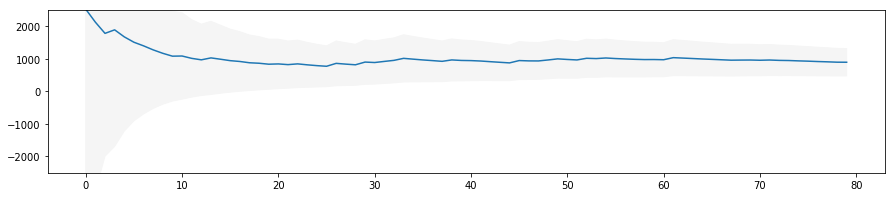

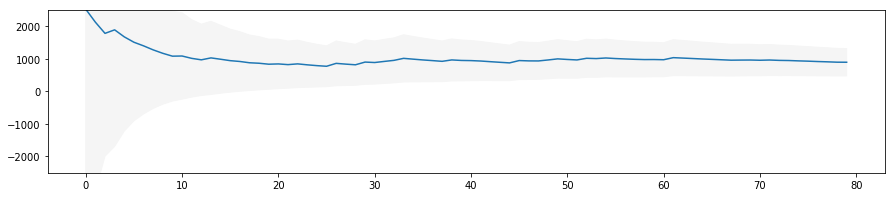

In [11]:
std_sigma2_log = np.sqrt(np.array(regmodel.var_sigma2_log))

plt.figure(figsize=(15, 3))
plt.plot(regmodel.Esigma2_log)
plt.fill_between(np.arange(ndat),
                 np.array(regmodel.Esigma2_log) + 3. * std_sigma2_log,
                 np.array(regmodel.Esigma2_log) - 3. * std_sigma2_log,
                 color='whitesmoke'
                 )
plt.ylim(-2500, 2500)
plt.show()